In [2]:
import torch
from utils import DataManager, dataset_sizes, collect_training_data, compute_statistics, compute_average_accuracies, plot_lr_feature_importance
import matplotlib.pyplot as plt
from probes import CCSProbe, LRProbe, MMProbe, ALL_PROBES, TTPD_TYPES, measure_polarity_direction_lr, run_ray, get_average_feature_importance, TTPDTestConfigurable
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import pandas as pd

/Users/flohop/miniconda3/envs/truth_is_universal/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/flohop/miniconda3/envs/truth_is_universal/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment

In [3]:
model_family = 'Llama3' # options are 'Llama3', 'Llama2', 'Gemma', 'Gemma2' or 'Mistral'
model_size = '8B'
model_type = 'chat' # options are 'chat' or 'base'
layer = 12 # layer from which to extract activations

device = 'mps' if torch.mps.is_available() else 'cpu' # mps speeds up CCS training a fair bit but is not required
device = "cuda" if torch.cuda.is_available() else device # cuda speeds it up a bit more
device

'mps'

In [4]:
# define datasets used for training
train_sets = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans", "inventors", "neg_inventors", "animal_class",
                  "neg_animal_class", "element_symb", "neg_element_symb", "facts", "neg_facts"]

# train_sets = ["cities", "sp_en_trans", "inventors",  "animal_class", "element_symb", "facts"]

# get size of each training dataset to include an equal number of statements from each topic in training data
train_set_sizes = dataset_sizes(train_sets)

TTPD_CLASSES = [v for (k, v) in TTPD_TYPES]


### Parameter Hyper Optimization

In [ ]:
import ray

ray.init(num_cpus=4, ignore_reinit_error=True)

val_sets = ["cities_conj", "cities_disj", "sp_en_trans_conj", "sp_en_trans_disj",
                "inventors_conj", "inventors_disj", "animal_class_conj", "animal_class_disj",
                "element_symb_conj", "element_symb_disj", "facts_conj", "facts_disj",
                "common_claim_true_false", "counterfact_true_false"]

num_samples = 500
# Run optimization
final_probe, best_config, analysis = run_ray(train_sets, val_sets, num_samples=num_samples)

# Shutdown Ray
ray.shutdown()

### Feature importance

In [4]:
config = {
    "polarity_C": 0.00063124,                        # default regularization strength (unused here)
    "polarity_penalty": "l1",                 # typical default, though your code doesn't use it
    "polarity_solver": "liblinear",               # stable for small feature counts
    "polarity_max_iter": 1000,                # reasonable iteration cap

    "use_scaler": False,

    "features": ["proj_t_g", "proj_p", "proj_t_p_inter"],

    "final_penalty": None,                    # matches your LogisticRegression(penalty=None)
    "final_C": 0.16657,                          # not used since penalty=None
    "final_solver": "lbfgs",                  # sklearn default for multi-purpose use
    "final_max_iter": 1000                    # matches your pattern of long convergence caps
}

Averaging coefficients: 100%|██████████| 10/10 [00:00<00:00, 49.96it/s]


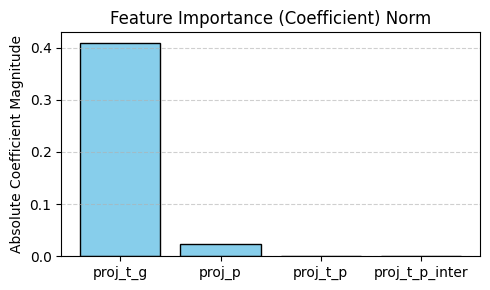

Averaging coefficients: 100%|██████████| 10/10 [00:00<00:00, 42.34it/s]


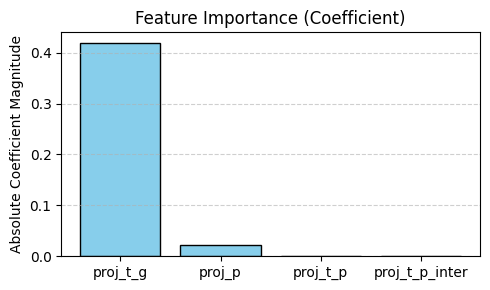

Averaging coefficients: 100%|██████████| 10/10 [00:00<00:00, 56.10it/s]


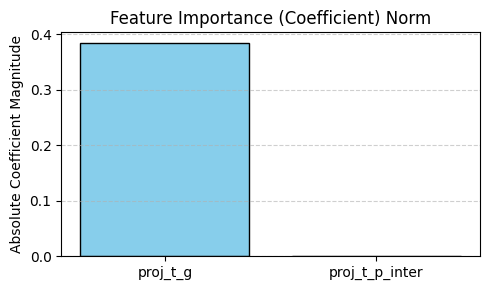

Averaging coefficients: 100%|██████████| 10/10 [00:00<00:00, 75.63it/s]


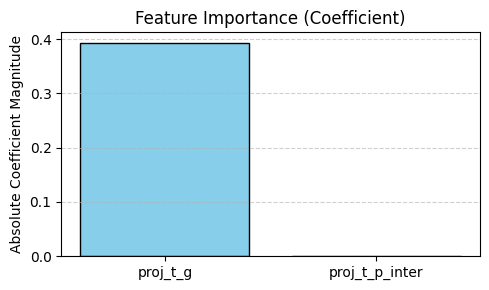

Averaging coefficients: 100%|██████████| 10/10 [00:00<00:00, 53.69it/s]


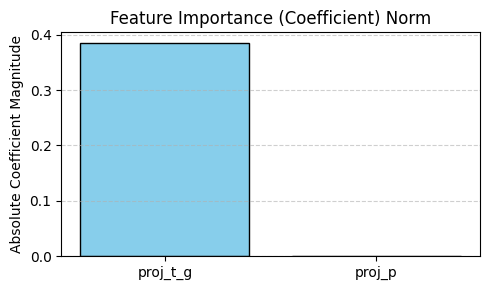

Averaging coefficients: 100%|██████████| 10/10 [00:00<00:00, 54.80it/s]


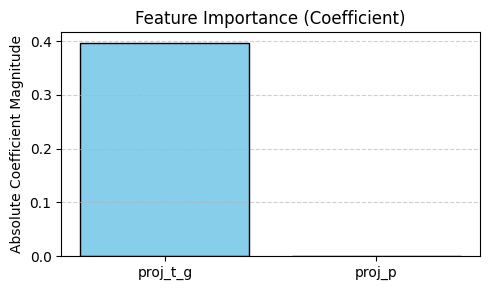

Averaging coefficients: 100%|██████████| 10/10 [00:00<00:00, 61.74it/s]


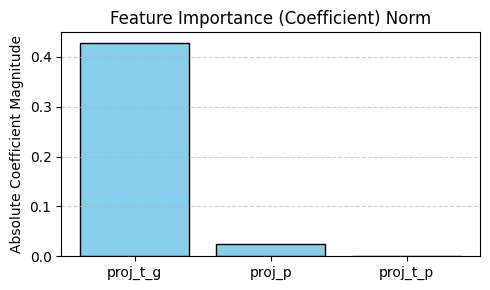

Averaging coefficients: 100%|██████████| 10/10 [00:00<00:00, 70.17it/s]


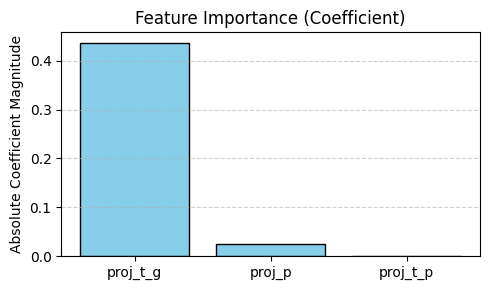

Averaging coefficients: 100%|██████████| 10/10 [00:00<00:00, 51.41it/s]


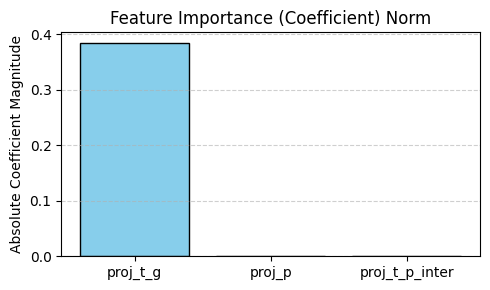

Averaging coefficients: 100%|██████████| 10/10 [00:00<00:00, 45.81it/s]


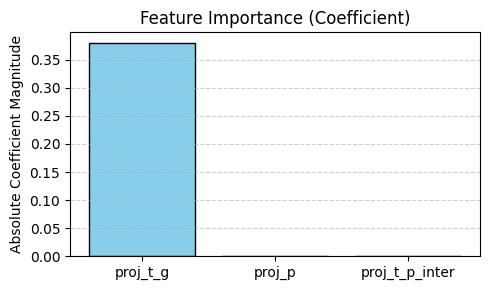

In [5]:


features_config = [
    ["proj_t_g", "proj_p", "proj_t_p", "proj_t_p_inter"],
    ["proj_t_g", "proj_t_p_inter"],
    ["proj_t_g", "proj_p"],
    ["proj_t_g", "proj_p", "proj_t_p"],
    ["proj_t_g", "proj_p", "proj_t_p_inter"],
]

acts_centered_train, acts_train, labels_train, polarities_train = collect_training_data(
        train_sets, train_set_sizes, model_family, model_size, model_type, layer)

for feature_config in features_config:
    config["features"] = feature_config

    for use_scaler in [True, False]:
        config["use_scaler"] = use_scaler

        avg_coef = get_average_feature_importance(acts_centered_train, acts_train, labels_train, polarities_train, runs=10, config=config)

        title = "Feature Importance"

        if use_scaler:
            title += " Norm"

        plot_lr_feature_importance(avg_coef, feature_names=feature_config, title=title)




### Polarity direction accuracy

In [ ]:
val_sets = ["cities_conj", "cities_disj", "sp_en_trans_conj", "sp_en_trans_disj",
                "inventors_conj", "inventors_disj", "animal_class_conj", "animal_class_disj",
                "element_symb_conj", "element_symb_disj", "facts_conj", "facts_disj",
                "common_claim_true_false", "counterfact_true_false"]

val_set_sizes = dataset_sizes(val_sets)

cv_train_sets = np.array(train_sets)
cv_test_sets = np.array(val_sets)
acts_centered, acts, labels, polarities = collect_training_data(cv_train_sets, train_set_sizes, model_family,
                                                                    model_size, model_type, layer)

# Test set
t_acts_centered, t_acts, t_labels, t_polarities = collect_training_data(cv_test_sets, dataset_sizes(val_sets), model_family, model_size, model_type, layer)

measure_polarity_direction_lr(acts, polarities, t_acts, t_polarities)


### Save Lie vector of TTPD

In [19]:
import os
from probes import TTPD

current_dir = os.getcwd()

# 1. Train TTPD
acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family,
                                                                                model_size, model_type, layer)
probe = TTPD.from_data(acts_centered, acts, labels, polarities)

weights = torch.tensor(probe.LR.coef_, dtype=torch.float32).squeeze()  # shape [n_features]

torch.save(weights, os.path.join(current_dir, "LRprobe.pt"))

### Unseen topics

In [14]:
# compare TTPD, LR and CCS on topic-specific datasets
probe_types = [t for (name, t) in ALL_PROBES]
results = {t: defaultdict(list) for t in probe_types}
num_iter = 3

TTPD_CLASSES = [v for (k, v) in TTPD_TYPES]

ttpd_coef = None

total_iterations = len(probe_types) * num_iter * len(train_sets)
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            indices = np.arange(0, 12, 2)
            for i in indices:
                cv_train_sets = np.delete(np.array(train_sets), [i, i+1], axis=0)
                # load training data
                acts_centered, acts, labels, polarities = collect_training_data(cv_train_sets, train_set_sizes, model_family,
                                                                                model_size, model_type, layer)

                if probe_type == TTPDTestConfigurable:
                    probe = probe_type.from_data(acts_centered, acts, labels, polarities, config=config)
                elif probe_type in TTPD_CLASSES:
                    probe = probe_type.from_data(acts_centered, acts, labels, polarities)
                    if ttpd_coef is None:
                        ttpd_coef = probe.coef
                    else:
                        ttpd_coef += probe.coef
                elif probe_type == LRProbe:
                    probe = LRProbe.from_data(acts, labels)
                elif probe_type == CCSProbe:
                    acts_affirm = acts[polarities == 1.0]
                    acts_neg = acts[polarities == -1.0]
                    labels_affirm = labels[polarities == 1.0]
                    mean_affirm = torch.mean(acts_affirm, dim=0)
                    mean_neg = torch.mean(acts_neg, dim=0)
                    acts_affirm = acts_affirm - mean_affirm
                    acts_neg = acts_neg - mean_neg
                    probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
                elif probe_type == MMProbe:
                    probe = MMProbe.from_data(acts, labels)

                # evaluate classification accuracy on held out datasets
                dm = DataManager()
                for j in range(0,2):
                    dm.add_dataset(train_sets[i+j], model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                    acts, labels = dm.data[train_sets[i+j]]

                    # classifier specific predictions
                    if probe_type == CCSProbe:
                        if j == 0:
                            acts = acts - mean_affirm
                        if j == 1:
                            acts = acts - mean_neg
                    predictions = probe.pred(acts)
                    results[probe_type][train_sets[i+j]].append((predictions == labels).float().mean().item())
                    pbar.update(1)


stat_results = compute_statistics(results)

# Compute mean accuracies and standard deviations for each probe type
probe_accuracies = compute_average_accuracies(results, num_iter)

for probe_type, stats in probe_accuracies.items():
    print(f"{probe_type}:")
    print(f"  Mean Accuracy: {stats['mean']*100:.2f}%")
    print(f"  Standard Deviation of the mean accuracy: {stats['std_dev']*100:.2f}%")

Training and evaluating classifiers:   0%|          | 0/144 [00:00<?, ?it/s]

Got here:  0


Training and evaluating classifiers:   3%|▎         | 4/144 [00:50<29:17, 12.55s/it]  


KeyboardInterrupt: 

In [ ]:
probes = [p for (t, p ) in ALL_PROBES]
titles = [t for (t, p) in ALL_PROBES]

fig, axes = plt.subplots(figsize=(14, 6), ncols=len(probes))

if len(probes) == 1:
    axes = [axes]


for t, (ax, key) in enumerate(zip(axes, probes)):
    grid = [[stat_results[key]['mean'][dataset]] for dataset in train_sets]
    grid_std = [[stat_results[key]['std'][dataset]] for dataset in train_sets]

    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')

    for i, row in enumerate(grid):
        for j, use_scaler in enumerate(row):
            ax.text(j, i, f'{round(grid[i][j] * 100):2d} $\pm$ {round(grid_std[i][j] * 100):2d}',
                    ha='center', va='center', fontsize=13)

    ax.set_yticks(range(len(train_sets)))
    ax.set_xticks([])
    ax.set_title(titles[t], fontsize=12)

# y tick labels only on first subplot
axes[0].set_yticklabels(train_sets, fontsize=12)
for ax in axes[1:]:
    ax.set_yticklabels([])

cbar = fig.colorbar(im, ax=axes, shrink=0.6, location="right")
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Classification accuracies", fontsize=15)
plt.show()


### Generalisation to logical conjunctions and disjunctions

In [ ]:
# compare TTPD, LR, CCS and MM on logical conjunctions and disjunctions
val_sets = ["cities_conj", "cities_disj", "sp_en_trans_conj","sp_en_trans_disj",
             "inventors_conj", "inventors_disj", "animal_class_conj", "animal_class_disj",
               "element_symb_conj", "element_symb_disj", "facts_conj", "facts_disj",
            "common_claim_true_false", "counterfact_true_false"]


probe_types = [t for (name, t) in ALL_PROBES]
results = {t: defaultdict(list) for t in probe_types}

TTPD_CLASSES = [v for (k, v) in TTPD_TYPES]


num_iter = 20

total_iterations = len(probe_types) * num_iter
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, model_size,
                                                                             model_type, layer)

            if probe_type == TTPDTestConfigurable:
                    probe = probe_type.from_data(acts_centered, acts, labels, polarities, config=config)
            elif probe_type in TTPD_CLASSES:
                probe = probe_type.from_data(acts_centered, acts, labels, polarities)
            elif probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            elif probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            elif probe_type == MMProbe:
                probe = MMProbe.from_data(acts, labels)

            # evaluate classification accuracy on validation datasets
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set] # retrieve the activations and labels that were just added to the DM
                
                # classifier specific predictions
                if probe_type == CCSProbe:
                    acts = acts - (mean_affirm + mean_neg)/2
                predictions = probe.pred(acts) # one prediction per example. 0 if we think its a lie, 1 if we predicte its true

                # compare prediction with ground truth labels and average it
                results[probe_type][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

stat_results = compute_statistics(results)

# Compute mean accuracies and standard deviations for each probe type
probe_accuracies = compute_average_accuracies(results, num_iter)

for probe_type, stats in probe_accuracies.items():
    print(f"{probe_type}:")
    print(f"  Mean Accuracy: {stats['mean']*100:.2f}%")
    print(f"  Standard Deviation of the mean accuracy: {stats['std_dev']*100:.2f}%")

In [ ]:

probes = [p for (t, p ) in ALL_PROBES]
titles = [t for (t, p) in ALL_PROBES]

fig, axes = plt.subplots(figsize=(14, 6), ncols=len(probes))

if len(probes) == 1:
    axes = [axes]


for t, (ax, key) in enumerate(zip(axes, probes)):
    grid = [[stat_results[key]['mean'][dataset]] for dataset in val_sets]
    grid_std = [[stat_results[key]['std'][dataset]] for dataset in val_sets]

    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')

    for i, row in enumerate(grid):
        for j, use_scaler in enumerate(row):
            ax.text(j, i, f'{round(grid[i][j] * 100):2d} $\pm$ {round(grid_std[i][j] * 100):2d}',
                    ha='center', va='center', fontsize=13)

    ax.set_yticks(range(len(val_sets)))
    ax.set_xticks([])
    ax.set_title(titles[t], fontsize=12)

# y tick labels only on first subplot
axes[0].set_yticklabels(val_sets, fontsize=12)
for ax in axes[1:]:
    ax.set_yticklabels([])

cbar = fig.colorbar(im, ax=axes, shrink=0.6, location='right')
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Classification accuracies", fontsize=15)
plt.show()



### Generalisation to German statements

In [ ]:
# compare TTPD, LR, CCS and MM on statements translated to german
val_sets = ["cities_de", "neg_cities_de", "sp_en_trans_de", "neg_sp_en_trans_de", "inventors_de", "neg_inventors_de", "animal_class_de",
                  "neg_animal_class_de", "element_symb_de", "neg_element_symb_de", "facts_de", "neg_facts_de"]

probe_types = [t for (name, t) in ALL_PROBES]
results = {t: defaultdict(list) for t in probe_types}

num_iter = 20

total_iterations = len(probe_types) * num_iter
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, model_size,
                                                                                           model_type, layer)

            if probe_type == TTPDTestConfigurable:
                    probe = probe_type.from_data(acts_centered, acts, labels, polarities, config=config)
            elif probe_type in TTPD_CLASSES:
                probe = probe_type.from_data(acts_centered, acts, labels, polarities)
            elif probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            elif probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            elif probe_type == MMProbe:
                probe = MMProbe.from_data(acts, labels)

            # evaluate classification accuracy on validation datasets
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
                
                # classifier specific predictions
                if probe_type == CCSProbe:
                    acts = acts - (mean_affirm + mean_neg)/2
                predictions = probe.pred(acts)
                
                results[probe_type][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

stat_results = compute_statistics(results)

# Compute mean accuracies and standard deviations for each probe type
probe_accuracies = compute_average_accuracies(results, num_iter)

for probe_type, stats in probe_accuracies.items():
    print(f"{probe_type}:")
    print(f"  Mean Accuracy: {stats['mean']*100:.2f}%")
    print(f"  Standard Deviation of the mean accuracy: {stats['std_dev']*100:.2f}%")

In [ ]:
probes = [p for (t, p ) in ALL_PROBES]
titles = [t for (t, p) in ALL_PROBES]

fig, axes = plt.subplots(figsize=(14, 6), ncols=len(probes))


if len(probes) == 1:
    axes = [axes]

for t, (ax, key) in enumerate(zip(axes, probes)):
    grid = [[stat_results[key]['mean'][dataset]] for dataset in val_sets]
    grid_std = [[stat_results[key]['std'][dataset]] for dataset in val_sets]

    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')

    for i, row in enumerate(grid):
        for j, use_scaler in enumerate(row):
            ax.text(j, i, f'{round(grid[i][j] * 100):2d} $\pm$ {round(grid_std[i][j] * 100):2d}',
                    ha='center', va='center', fontsize=13)

    ax.set_yticks(range(len(val_sets)))
    ax.set_xticks([])
    ax.set_title(titles[t], fontsize=12)

# y tick labels only on first subplot
axes[0].set_yticklabels(val_sets, fontsize=12)
for ax in axes[1:]:
    ax.set_yticklabels([])

cbar = fig.colorbar(im, ax=axes, shrink=0.6, location='right')
cbar.ax.tick_params(labelsize=12)

fig.suptitle("Classification accuracies", fontsize=15)
plt.show()


### Displaying generalisation to Conjunctions, Disjunctions and German statements in one table

In [ ]:
# Define the validation sets and the probe types
val_sets = ["cities_conj", "cities_disj", "sp_en_trans_conj","sp_en_trans_disj",
             "inventors_conj", "inventors_disj", "animal_class_conj", "animal_class_disj",
               "element_symb_conj", "element_symb_disj", "facts_conj", "facts_disj", "cities_de", "neg_cities_de", "sp_en_trans_de", "neg_sp_en_trans_de", "inventors_de", "neg_inventors_de", "animal_class_de",
                  "neg_animal_class_de", "element_symb_de", "neg_element_symb_de", "facts_de", "neg_facts_de",
            "common_claim_true_false", "counterfact_true_false"]

probe_types = [t for (name, t) in ALL_PROBES]
results = {t: defaultdict(list) for t in probe_types}
num_iter = 20

TTPD_CLASSES = [v for (k, v) in TTPD_TYPES]

# Training and evaluating classifiers
total_iterations = len(probe_types) * num_iter
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar:
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, model_size,
                                                                                           model_type, layer)

            if probe_type == TTPDTestConfigurable:
                    probe = probe_type.from_data(acts_centered, acts, labels, polarities, config=config)
            elif probe_type in TTPD_CLASSES:
                probe = probe_type.from_data(acts_centered, acts, labels, polarities)
            elif probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            elif probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            elif probe_type == MMProbe:
                probe = MMProbe.from_data(acts, labels)

            # evaluate classification accuracy on validation datasets
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
                
                # classifier specific predictions
                if probe_type == CCSProbe:
                    acts = acts - (mean_affirm + mean_neg)/2
                predictions = probe.pred(acts)
                results[probe_type][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

In [ ]:
# Define the groups
groups = {
    'Conjunctions': [dataset for dataset in val_sets if dataset.endswith('_conj')],
    'Disjunctions': [dataset for dataset in val_sets if dataset.endswith('_disj')],
    'Affirmative German': [dataset for dataset in val_sets if dataset.endswith('_de') and not dataset.startswith('neg_')],
    'Negated German': [dataset for dataset in val_sets if dataset.startswith('neg_') and dataset.endswith('_de')],
    'common_claim_true_false': ['common_claim_true_false'],
    'counterfact_true_false': ['counterfact_true_false']
}

# Initialize group results
group_results = {probe_type: {group_name: [] for group_name in groups} for probe_type in probe_types}

# Process results to compute mean accuracies per group per classifier
for probe_type in probe_types:
    for n in range(num_iter):
        for group_name, group_datasets in groups.items():
            accuracies = []
            for dataset in group_datasets:
                accuracy = results[probe_type][dataset][n]
                accuracies.append(accuracy)
            mean_accuracy = sum(accuracies) / len(accuracies)
            group_results[probe_type][group_name].append(mean_accuracy)

# Compute statistics
stat_group_results = {probe_type: {'mean': {}, 'std': {}} for probe_type in probe_types}

for probe_type in probe_types:
    for group_name in groups:
        accuracies = group_results[probe_type][group_name]
        mean_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)
        stat_group_results[probe_type]['mean'][group_name] = mean_accuracy
        stat_group_results[probe_type]['std'][group_name] = std_accuracy

# Map probe types to classifier names

probe_type_to_name = {probe:name for (name, probe) in ALL_PROBES}

# probe_type_to_name = {
#     TTPD: 'TTPD',
#     TTPD4d: "TTPD4d",
#     TTPD3dTp: "TTPD3dTp",
#     TTPD3dTpInv: "TTPD3dTpInv",
#     LRProbe: 'LR',
#     CCSProbe: 'CCS',
#     MMProbe: 'MM'
# }

# Create DataFrames for mean accuracies and standard deviations
group_names = ['Conjunctions', 'Disjunctions', 'Affirmative German', 'Negated German', 'common_claim_true_false', 'counterfact_true_false']
classifier_names = [n for (n, _) in ALL_PROBES]
# classifier_names = ['TTPD', "TTPD4d", "TTPD3dTp", "TTPD3dTpInv", 'LR', 'CCS', 'MM']

mean_df = pd.DataFrame(index=group_names, columns=classifier_names)
std_df = pd.DataFrame(index=group_names, columns=classifier_names)

for probe_type in probe_types:
    classifier_name = probe_type_to_name[probe_type]
    for group_name in group_names:
        mean_accuracy = stat_group_results[probe_type]['mean'][group_name]
        std_accuracy = stat_group_results[probe_type]['std'][group_name]
        mean_df.loc[group_name, classifier_name] = mean_accuracy
        std_df.loc[group_name, classifier_name] = std_accuracy

num_classifiers = len(classifier_names)
fig, axes = plt.subplots(figsize=(2.5*num_classifiers, 6), ncols=num_classifiers)

for idx, classifier_name in enumerate(classifier_names):
    ax = axes[idx]
    mean_values = mean_df[classifier_name].values.astype(float)
    std_values = std_df[classifier_name].values.astype(float)

    # Create heatmap with a single column
    im = ax.imshow(mean_values[:, np.newaxis], vmin=0, vmax=1, cmap='plasma', aspect='auto')

    # Annotate the heatmap
    for i in range(len(group_names)):
        mean_accuracy = mean_values[i]
        std_accuracy = std_values[i]
        ax.text(0, i, f'{round(mean_accuracy * 100):2d} ± {round(std_accuracy * 100):2d}',
                ha='center', va='center', fontsize=14)

    # Set ticks and labels
    ax.set_xticks([])
    if idx == 0:
        ax.set_yticks(np.arange(len(group_names)))
        ax.set_yticklabels(group_names, fontsize=14)
    else:
        ax.set_yticks([])
    ax.set_title(classifier_name, fontsize=15)

# Add colorbar on the right
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), location='right', shrink=0.8)
cbar.ax.tick_params(labelsize=13)

fig.suptitle("Classification Accuracies", fontsize=17)
plt.show()

### Real world scenarios / lies

In [ ]:
probe_types = [t for (name, t) in ALL_PROBES]
results = {t: [] for t in probe_types}
num_iter = 50

total_iterations = len(probe_types) * num_iter
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family,
                                                                                           model_size, model_type,layer)
            if probe_type in TTPD_CLASSES:
                probe = probe_type.from_data(acts_centered, acts, labels, polarities)
            if probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            if probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_type == MMProbe:
                probe = MMProbe.from_data(acts, labels)

            # evaluate classification accuracy on real world scenarios
            dm = DataManager()
            real_world_dataset = "real_world_scenarios/all_unambiguous_replies"
            dm.add_dataset(real_world_dataset, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
            acts, labels = dm.data[real_world_dataset]
            
            # classifier specific predictions
            if probe_type == CCSProbe:
                acts = acts - (mean_affirm + mean_neg)/2

            predictions = probe.pred(acts)
            results[probe_type].append((predictions == labels).float().mean().item())
            pbar.update(1)

for probe_type in probe_types:
    mean = np.mean(results[probe_type])
    std = np.std(results[probe_type])
    print(f"{probe_type.__name__}:")
    print(f"  Mean Accuracy: {mean*100:.2f}%")
    print(f"  Standard Deviation: {std*100:.2f}%")